## Reminder: Q-learning

Q-learning is a model-free, off-policy, value-based reinforcement learning algorithm that aims to find the best series of actions based on the agent's current state.

- **model-free**: Learning from experience, no transition and reward function.
- **off-policy**: Learning from actions that are coutside the current policy, e.g., by taking random actions.
- **value-based**: Training the value function to learn which state is more valuable for taking action.

#### Q-function
In Q-learning, we keep a function called Q-function for choosing our next action in our current state. Therefore, it accepts the current state and current action as its parameters. You can think of the Q-function as a diary of the agent which keeps track of what rewards it collected in the past after choosing actions in different states.

![Q-function (source: Freecodecamp)](qfunction.png) (Source: Freecodecamp)

At the beginning, the Q-function is initialized **randomly** or based on a heuristic. The learning consists of multiple episodes and a new episode is created after the old one reached a terminal state and the Q-function has not converged yet.

In each episode, at each state, the agent chooses an action based on some policy. This policy is usually obtained using a simple method called **epsilon-greedy**, which balances **exploration** and **exploitation** by choosing betweenthem randomly. After taking the action and getting an immediate reward, the agent updates the Q-learning entry. The learning rate and discount factor determines to what extent newly acquired information overrides old information and the importance of future rewards, respectively.

#### Q-table
A Q-table is a table of rewards associated with optimal actions for each state in a given environment. It serves as a guide for the agent, helping to determine which actions are likely to yield the best outcomes. The Q-table initialized to zero and then dynamically updated during training to reflect the agent’s evolving understanding, enabling more informed decision-making.

<img alt="Q-table (source: Wikipedia)]" src="qtable.png" width=500> (Source: Wikipedia)

**Summary of steps of the Q-learning algorithm**:
1. Initialize a Q-table
2. Choose an action
3. Perform the action
4. Measure reward
5. Update the Q-table
6. Repeat from step 2

### Setup virtual display

In [22]:
%%capture
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
from ipywidgets import FloatProgress
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

### Install dependencies

In [2]:
%%capture
!pip install gym==0.23
!pip install pygame
!pip install numpy
!pip install imageio imageio_ffmpeg

### Imports

In [2]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

### 1) Set up environment, sample output

In [67]:
# create the FrozenLake-v1 environment using a 4x4 map and non-slippery version
env = gym.make("FrozenLake-v1",map_name="4x4",is_slippery=False)

In [49]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 2


In [50]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 0


### 2) Create and initialize Q-table

In [51]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [66]:
# create a Q-table of size (state_space, action_space) and initialize each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

In [53]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

### 3) Define policies

In [65]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    random_int = random.uniform(0,1)
    # if random_int > greater than epsilon -> exploitation
    if random_int > epsilon:
    # take the action with the highest value given a state
    # np.argmax can be useful here
        action = np.argmax(Qtable[state])
    # else -> exploration
    else:
        action = env.action_space.sample()
  
    return action

In [37]:
def greedy_policy(Qtable, state):
    # exploitation: take the action with the highest state, action value
    action = np.argmax(Qtable[state])
  
    return action

### 4) Define hyperparameters

In [70]:
n_training_episodes = 10000  # Total number of training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0            # Exploration probability at start
min_epsilon = 0.05           # Minimum exploration probability 
decay_rate = 0.0005          # Exponential decay rate for exploration probability

### 5) Train the model

In [63]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in trange(n_training_episodes):
        # reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        # reset the environment
        state = env.reset()
        step = 0
        done = False

        # repeat
        for step in range(max_steps):
            # choose the action using epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # take action At and observe Rt+1 and St+1
            # take action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)

            # update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]) 

            # if done, finish the episode
            if done:
                break
      
            # our state is the new state
            state = new_state
    return Qtable

In [55]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [56]:
# Trained q-learning table

Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378086, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

### 6) Model evaluation

In [62]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param Q: The Q-table
    :param seed: The evaluation seed array (for taxi-v3)
    """
    episode_rewards = []
    for episode in range(n_eval_episodes):
        if seed:
            state = env.reset(seed=seed[episode])
        else:
            state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0
    
        for step in range(max_steps):
            # take the action (index) with the maximum expected future reward given that state
            action = np.argmax(Q[state][:])
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
        
            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [57]:
# Evaluation
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


### 7) Visualization

In [61]:
def record_video(env, Qtable, out_directory, fps=1):
    images = []  
    done = False
    state = env.reset(seed=random.randint(0,500))
    img = env.render(mode='rgb_array')
    images.append(img)
    while not done:
    # take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(Qtable[state][:])
        state, reward, done, info = env.step(action) # next_state = state for recording logic
        img = env.render(mode='rgb_array')
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [58]:
video_path="content/replay.gif"
duration=1

In [59]:
record_video(env, Qtable_frozenlake, video_path, duration)

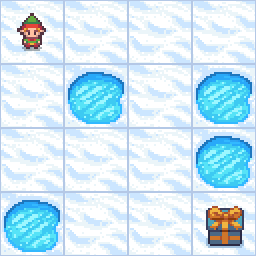

In [60]:
from IPython.display import Image
Image('content/replay.gif')

### 8) Questions
- What happens if you change the environment size (e.g., 8x8)?
- What happens if you change any of the hyperparameters? Which are helpful to tune?